## 0.Préambule

### Mot introductif

Ce projet de Machine Learning se concentre sur la création d'un système de recommandation de films, s'inspirant d'un article mettant en avant l'efficacité du Cosine Similarity dans les recommandations. Guidé par la passion pour le cinéma et motivé par les avancées de cette mesure de similarité, notre objectif est de développer un système précis et personnalisé pour recommander des films en se basant sur les préférences individuelles des utilisateurs. On s'est basé sur l'ariticle [suivant.](https://naomy-gomes.medium.com/the-cosine-similarity-and-its-use-in-recommendation-systems-cb2ebd811ce1)

 Après avoir récupéré les données via l'API TMDB, des analyses statistiques descriptives ont été effectuées pour comprendre la nature des données. En parallèle, un modèle de recommandation de films a été créé. Pour rendre l'expérience plus interactive, une application visuelle a été développée en utilisant la bibliothèque DASH, offrant une interface conviviale pour explorer les recommandations de films et interagir avec le système de recommandation.

### Importation des modules et packages

#### Pour les requêtes API

In [2]:
import requests
import json
import pandas as pd

#### Visualisation et analyse des données

In [1]:
# Lecture et traitement du dataframe
import pandas as pd 
import numpy as np 
import pickle

# Visualisation et analyse graphique des données
import matplotlib.pyplot as plt

# Visualisation et analyse cartographique des données
import geopandas as gpd
import contextily as ctx

# Corrélation entre les données
import seaborn as sns 


#### Modélisation

In [3]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### I. Récupération des données

#### a. Code 

Nous avons utilisé l'API TMDB pour récupérer 10k films même si après nettoyage de la base de donnée nous en aurons moins.

On commence par récupérer les *id* des films "popular", puis on effectue des requêtes pour avoir les détails de tous ses films. 

À la fin des requêtes, on exporte le fichier en JSON. Le fichier fait 1/2Go, ce qui s'explique notamment par la quantité de texte importante dans le dataframe.

In [ ]:
# Votre clé d'API TMDb
api_key = '28c6630049f5d468217e4f34963c03a6'

# URL de base de l'API TMDb pour les films populaires
base_url_popular = 'https://api.themoviedb.org/3/movie/popular'

# Nombre total de films à récupérer
total_movies = 10000

# Nombre de films à récupérer par requête
movies_per_request = 20

# Champs de base pour les films
fields = 'id'  # Ajoutez les champs que vous souhaitez récupérer ici

# Liste pour stocker tous les films avec leurs détails
all_movies_details = []

# Nombre de requêtes nécessaires pour obtenir le nombre total de films
num_requests = total_movies // movies_per_request

# Effectuer les requêtes pour récupérer les films
for page in range(1, num_requests + 1):
    params = {
        'api_key': api_key,
        'page': page,
        'fields': fields
    }
    response = requests.get(base_url_popular, params=params)#, timeout=10)  # Définir un délai d'attente de 10 secondes

    if response.status_code == 200:
        movies_data = response.json()
        movies_reco = movies_data.get('results', [])

            # Pour chaque film, récupérer les détails supplémentaires
        for movie in movies_reco:
            movie_id = movie['id']
            movie_details_url = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&append_to_response=credits,keywords'
            movie_details_response = requests.get(movie_details_url)
            if movie_details_response.status_code == 200:
                movie_details = movie_details_response.json()
                all_movies_details.append(movie_details)
                print(f"Film {movie['title']} récupéré avec détails supplémentaires.")
            else:
                print(f"Erreur lors de la récupération des détails pour {movie['title']}. Statut : {movie_details_response.status_code}")
        print(f"Page {page} récupérée. Total de films récupérés : {len(all_movies_details)}")

    else:
        print(f"Erreur lors de la requête pour la page {page}. Statut : {response.status_code}")


    if len(all_movies_details) >= total_movies:
        break

# Enregistrer les données complètes dans un fichier JSON
with open('movies_data_complete.json', 'w', encoding='utf-8') as f:
    json.dump(all_movies_details, f, ensure_ascii=False, indent=4)

print("Récupération des films avec détails complets terminée. Les données ont été enregistrées dans movies_data_complete.json.")

#### b. Affichage du DataFrame

In [4]:
movies_data=pd.read_json('movies_data_complete.json')
movies_data.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits,keywords
0,False,/1X7vow16X7CnCoexXh4H4F2yDJv.jpg,None,200000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",https://www.killersoftheflowermoonmovie.com,466420,tt5537002,en,Killers of the Flower Moon,...,206,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Greed is an animal that hungers for blood.,Killers of the Flower Moon,False,7.622,1479,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi..."
1,False,/zIYROrkHJPYB3VTiW1L9QVgaQO.jpg,None,40000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://freelance.movie,897087,tt15744298,en,Freelance,...,108,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Retirement didn't suit him.,Freelance,False,6.539,322,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta..."
2,False,/r1eCvALF6fN7anVYL8Zn7PaceD1.jpg,None,125000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",https://www.wonkamovie.com,787699,tt6166392,en,Wonka,...,117,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Every good thing in this world started with a ...,Wonka,False,7.271,316,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}..."
3,False,/k1KrbaCMACQiq7EA0Yhw3bdzMv7.jpg,"{'id': 489724, 'name': 'The Trolls Collection'...",95000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",https://www.delfi.lt,901362,tt14362112,en,Trolls Band Together,...,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There are some new trolls on the block.,Trolls Band Together,False,7.172,379,"{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}..."
4,False,/9PqD3wSIjntyJDBzMNuxuKHwpUD.jpg,None,0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",https://www.netflix.com/title/81218917,1075794,tt5755238,en,Leo,...,102,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Breaking out this November.,Leo,False,7.609,597,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'..."


In [5]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  10000 non-null  bool   
 1   backdrop_path          9922 non-null   object 
 2   belongs_to_collection  2578 non-null   object 
 3   budget                 10000 non-null  int64  
 4   genres                 10000 non-null  object 
 5   homepage               10000 non-null  object 
 6   id                     10000 non-null  int64  
 7   imdb_id                9958 non-null   object 
 8   original_language      10000 non-null  object 
 9   original_title         10000 non-null  object 
 10  overview               10000 non-null  object 
 11  popularity             10000 non-null  float64
 12  poster_path            9996 non-null   object 
 13  production_companies   10000 non-null  object 
 14  production_countries   10000 non-null  object 
 15  rel

### II. Nettoyage des données

#### II.1. Choix des variables utiles

Tout d'abord, on récupère les données qui nous seront utiles dans la création de l'application et on supprime les films doublons.

On ne garde que les films qui sont sortis et dont le revenu et le runtime sont strictement positifs. 

In [6]:
selected_columns=['id','title','original_title','overview','release_date','adult','popularity','vote_average','vote_count','poster_path','runtime','genres','production_companies','production_countries','spoken_languages','credits','keywords','status']
movies_data=movies_data[selected_columns]
movies_data= movies_data.drop_duplicates(subset='title', keep='first')
movies_data=movies_data[movies_data.status=='Released']
movies_data= movies_data[movies_data.runtime!=0]

Enfin, on ne conserve que l'année de sortie du film.

In [7]:
movies_data.release_date=pd.to_datetime(movies_data.release_date, format='%Y-%m-%d', errors = 'ignore')
movies_data['release_year']=movies_data['release_date'].dt.year 
movies_data.drop(['release_date','status'],axis=1,inplace=True)
movies_data=movies_data.reset_index(drop=True)

####  II.2. Résolution des problèmes du dataset

On travaille à présent sur les différentes colonnes où les données ne sont pas directement exploitables comme *genres*, *productions_companies* etc. On ne conserve que les informations importantes : dans chaque dictionnaire, on conserve les valeurs de *name*. 

In [8]:
movies_data.loc[0].genres

[{'id': 80, 'name': 'Crime'},
 {'id': 18, 'name': 'Drama'},
 {'id': 36, 'name': 'History'}]

On crée une fonction pour directement extraire les données importanes de *genres, production_countries, spoken_languages & production_companies*

In [9]:
def convert(text):
    L = []
    for i in text:
        L.append(i["name"]) 
    return L 
movies_data['genres'] = movies_data['genres'].apply(convert)
movies_data['production_countries'] = movies_data['production_countries'].apply(convert)
movies_data['spoken_languages']=movies_data['spoken_languages'].apply(convert)
movies_data['production_companies']=(movies_data['production_companies'].apply(convert)).apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
#Je garde que la principale entreprise de production.
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,credits,keywords,release_year
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,[United States of America],"[English, Français, Latin]","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi...",2023
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,[United States of America],"[English, Español]","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta...",2023
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,"[United Kingdom, United States of America]",[English],"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}...",2023
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,[United States of America],"[English, Lietuvių]","{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}...",2023
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,"[Australia, United States of America]",[English],"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'...",2023


On gère la colonnes *keywords* de la même manière sauf qu'il existe des films sans mots clés. On supprime ces films car cette colonne est très importante pour le modèle que l'on va créer.

In [57]:
movies_data['keywords'] = movies_data['keywords'].apply(lambda x: x['keywords'] if isinstance(x, dict) and 'keywords' in x else None) # regarder Robot Apocalypse Keywords
movies_data = movies_data[movies_data['keywords'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
movies_data["keywords"]=movies_data["keywords"].apply(convert)
movies_data.reset_index(drop=True,inplace=True)

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,keywords,release_year,cast,crew
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,[United States of America],"[English, Français, Latin]","[husband wife relationship, based on novel or ...",2023,"[Leonardo DiCaprio, Lily Gladstone, Robert De ...",[Martin Scorsese]
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,[United States of America],"[English, Español]","[coup d'etat, dictatorship, political assassin...",2023,"[John Cena, Alison Brie, Juan Pablo Raba]",[Pierre Morel]
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,"[United Kingdom, United States of America]",[English],"[chocolate, musical, prequel]",2023,"[Timothée Chalamet, Calah Lane, Keegan-Michael...",[Paul King]
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,[United States of America],"[English, Lietuvių]","[pop star, brother, musical, sequel, based on ...",2023,"[Anna Kendrick, Justin Timberlake, Camila Cabe...",[Walt Dohrn]
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,"[Australia, United States of America]",[English],"[classroom, musical, bucket list]",2023,"[Adam Sandler, Bill Burr, Cecily Strong]",[Robert Smigel]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8287,11157,She-Devil,She-Devil,A cunning and resourceful housewife vows reven...,False,27.259,5.889,348,/jWYAXtdYF804aT1muO0G6FuR2Fa.jpg,99,[Comedy],Orion Pictures,[United States of America],[English],"[career woman, deceived wife, revenge, author,...",1989,"[Meryl Streep, Roseanne Barr, Ed Begley Jr.]",[Susan Seidelman]
8288,11085,Mutiny on the Bounty,Mutiny on the Bounty,The Bounty leaves Portsmouth in 1787. Its dest...,False,21.260,7.000,269,/caxk06SANEacvycZFiApv1LA6Kl.jpg,185,"[Adventure, Drama, History]",Arcola Pictures,[United States of America],"[English, Français, Nederlands, ]","[exotic island, mutiny, captain, heart-throb, ...",1962,"[Marlon Brando, Trevor Howard, Richard Harris]",[Lewis Milestone]
8289,152747,All Is Lost,All Is Lost,"During a solo voyage in the Indian Ocean, a ve...",False,29.012,6.600,1504,/9cVA4oX2xHgiglv6hemxwAaofsq.jpg,106,"[Action, Adventure, Drama]",Before the Door Pictures,[United States of America],[English],"[sea, yacht, alone, dying of thirst, struggle ...",2013,[Robert Redford],[J.C. Chandor]
8290,26149,Music of the Heart,Music of the Heart,Story of a schoolteacher's struggle to teach v...,False,30.409,6.704,199,/maqYjELEaeCr3EtN7KNLTAwycS5.jpg,124,"[Music, Drama]",Craven-Maddalena Films,[United States of America],"[Español, English]","[violin, music teacher, biography, based on tr...",1999,"[Meryl Streep, Cloris Leachman, Henry Dinhofer]",[Wes Craven]


Enfin, on sépare les *credits* entre le *cast* et le *crew*, où respectivement on récupère les trois acteurs principaux et le réalisateur.

In [11]:
movies_data['cast'] = movies_data['credits'].apply(lambda x: x.get('cast') if isinstance(x, dict) else None)
movies_data['crew'] = movies_data['credits'].apply(lambda x: x.get('crew') if isinstance(x, dict) else None)
movies_data.drop("credits", axis=1, inplace=True)

Création de la fonction récupérant les trois acteurs principaux et de la fonction récupérant le réalisateur.

In [54]:
def convert3(text):
    L = []
    counter = 0
    for i in text:
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L 

def fetch_director(text):
    L = []
    for i in text:
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L 
movies_data["cast"]=movies_data["cast"].apply(convert3)
movies_data["crew"]=movies_data["crew"].apply(fetch_director)
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,keywords,release_year,cast,crew
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,[United States of America],"[English, Français, Latin]","[husband wife relationship, based on novel or ...",2023,"[Leonardo DiCaprio, Lily Gladstone, Robert De ...",[Martin Scorsese]
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,[United States of America],"[English, Español]","[coup d'etat, dictatorship, political assassin...",2023,"[John Cena, Alison Brie, Juan Pablo Raba]",[Pierre Morel]
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,"[United Kingdom, United States of America]",[English],"[chocolate, musical, prequel]",2023,"[Timothée Chalamet, Calah Lane, Keegan-Michael...",[Paul King]
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,[United States of America],"[English, Lietuvių]","[pop star, brother, musical, sequel, based on ...",2023,"[Anna Kendrick, Justin Timberlake, Camila Cabe...",[Walt Dohrn]
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,"[Australia, United States of America]",[English],"[classroom, musical, bucket list]",2023,"[Adam Sandler, Bill Burr, Cecily Strong]",[Robert Smigel]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8902,11157,She-Devil,She-Devil,A cunning and resourceful housewife vows reven...,False,27.259,5.889,348,/jWYAXtdYF804aT1muO0G6FuR2Fa.jpg,99,[Comedy],Orion Pictures,[United States of America],[English],"[career woman, deceived wife, revenge, author,...",1989,"[Meryl Streep, Roseanne Barr, Ed Begley Jr.]",[Susan Seidelman]
8903,11085,Mutiny on the Bounty,Mutiny on the Bounty,The Bounty leaves Portsmouth in 1787. Its dest...,False,21.260,7.000,269,/caxk06SANEacvycZFiApv1LA6Kl.jpg,185,"[Adventure, Drama, History]",Arcola Pictures,[United States of America],"[English, Français, Nederlands, ]","[exotic island, mutiny, captain, heart-throb, ...",1962,"[Marlon Brando, Trevor Howard, Richard Harris]",[Lewis Milestone]
8904,152747,All Is Lost,All Is Lost,"During a solo voyage in the Indian Ocean, a ve...",False,29.012,6.600,1504,/9cVA4oX2xHgiglv6hemxwAaofsq.jpg,106,"[Action, Adventure, Drama]",Before the Door Pictures,[United States of America],[English],"[sea, yacht, alone, dying of thirst, struggle ...",2013,[Robert Redford],[J.C. Chandor]
8905,26149,Music of the Heart,Music of the Heart,Story of a schoolteacher's struggle to teach v...,False,30.409,6.704,199,/maqYjELEaeCr3EtN7KNLTAwycS5.jpg,124,"[Music, Drama]",Craven-Maddalena Films,[United States of America],"[Español, English]","[violin, music teacher, biography, based on tr...",1999,"[Meryl Streep, Cloris Leachman, Henry Dinhofer]",[Wes Craven]


### III. Visualisation des données

In [22]:
genres_exploded = movies_data['genres'].explode()
# Compter le nombre de films par genre
genre_counts = genres_exploded.value_counts()
print("Nombre de films par genre :")
print(genre_counts)

Nombre de films par genre :
genres
Drama              3601
Comedy             2845
Thriller           2392
Action             2388
Adventure          1623
Romance            1403
Horror             1333
Crime              1221
Family             1193
Science Fiction    1141
Fantasy            1140
Animation          1075
Mystery             821
History             394
War                 318
Music               237
TV Movie            202
Western             185
Documentary          91
Name: count, dtype: int64


In [23]:
genres_exploded.head(20)

0              Crime
0              Drama
0            History
1             Action
1             Comedy
2             Comedy
2             Family
2            Fantasy
3          Animation
3             Family
3              Music
3            Fantasy
3             Comedy
4          Animation
4             Comedy
4             Family
5              Drama
5            Mystery
5           Thriller
5    Science Fiction
Name: genres, dtype: object

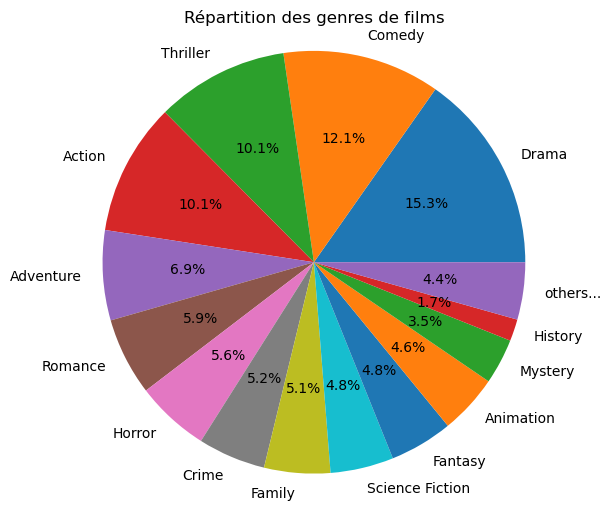

In [24]:
totale=genre_counts.sum()
list_principale=list(genre_counts[:14])
list_principale.append(totale-sum(list_principale))
list_genre=list(genre_counts[:14].index)
list_genre.append('others...')
plt.figure(figsize=(6, 6))
plt.pie(list_principale, labels=list_genre, autopct='%1.1f%%')
plt.title('Répartition des genres de films')
plt.axis('equal')  
plt.show()

# Pays Producteurs

In [25]:
pays_exploded = movies_data['production_countries'] .explode()
# Compter le nombre de films par genre
pays_counts = pays_exploded.value_counts()
print("Nombre de films par pays :")
print(pays_counts)

Nombre de films par pays :
production_countries
United States of America    6724
United Kingdom              1246
France                       707
Canada                       610
Japan                        521
                            ... 
Georgia                        1
Bolivia                        1
Latvia                         1
Iraq                           1
Liechtenstein                  1
Name: count, Length: 97, dtype: int64


In [26]:
pays_counts[:15]

production_countries
United States of America    6724
United Kingdom              1246
France                       707
Canada                       610
Japan                        521
Germany                      454
Italy                        240
Spain                        199
China                        177
Australia                    166
South Korea                  145
Hong Kong                    138
Belgium                      136
Mexico                        90
Ireland                       89
Name: count, dtype: int64

In [27]:
pays_counts.sum()

12709

In [28]:
list_principale=pays_counts[:16]
list_principale.sum()

11725

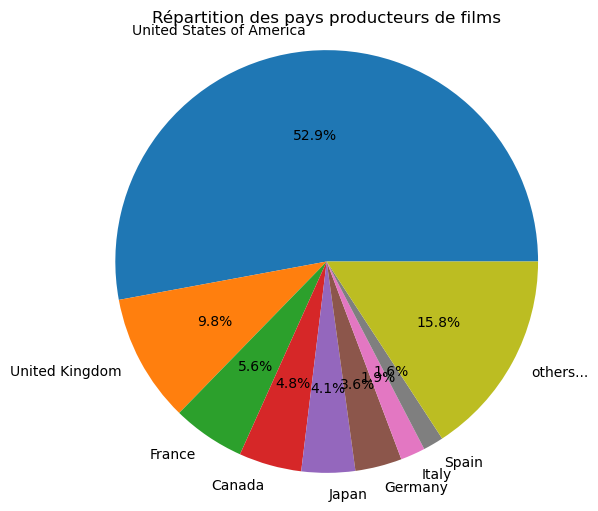

In [29]:
totale=pays_counts.sum()
list_principale=list(pays_counts[:8])
list_principale.append(totale-sum(list_principale))
list_pays=list(pays_counts[:8].index)
list_pays.append('others...')
plt.figure(figsize=(6, 6))
plt.pie(list_principale, labels=list_pays, autopct='%1.1f%%')
plt.title('Répartition des pays producteurs de films')
plt.axis('equal')  
plt.show()

# Genres et Budget

In [30]:
top_5_expensive_movies =movies_data.nlargest(5, 'budget')

In [31]:
top_5_expensive_movies.head()

,adult,backdrop_path,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits,keywords
56,False,/8rpDcsfLJypbO6vREc0547VKqEv.jpg,460000000,"[Science Fiction, Adventure, Action]",https://www.avatar.com/movies/avatar-the-way-o...,76600,tt1630029,en,Avatar: The Way of Water,Set more than a decade after the events of the...,...,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.651,10365,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 3737, 'name': 'dying and ..."
298,False,/wQ0r0JRs7elHSKg1SFtdWdKTYKi.jpg,379000000,"[Adventure, Action, Fantasy]",https://movies.disney.com/pirates-of-the-carib...,1865,tt1298650,en,Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,...,137,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Live Forever Or Die Trying.,Pirates of the Caribbean: On Stranger Tides,False,6.540,13290,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 658, 'name': 'sea'}, {'id..."
426,False,/6YwkGolwdOMNpbTOmLjoehlVWs5.jpg,365000000,"[Action, Adventure, Science Fiction]",http://marvel.com/movies/movie/193/avengers_ag...,99861,tt2395427,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,...,141,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A new age has come.,Avengers: Age of Ultron,False,7.274,21979,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 310, 'name': 'artificial ..."
335,False,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,356000000,"[Adventure, Science Fiction, Action]",https://www.marvel.com/movies/avengers-endgame,299534,tt4154796,en,Avengers: Endgame,After the devastating events of Avengers: Infi...,...,181,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Avenge the fallen.,Avengers: Endgame,False,8.261,24185,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 9715, 'name': 'superhero'..."
15,False,/4XM8DUTQb3lhLemJC51Jx4a2EuA.jpg,340000000,"[Action, Crime, Thriller]",https://fastxmovie.com,385687,tt5433140,en,Fast X,Over many missions and against impossible odds...,...,142,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The end of the road begins.,Fast X,False,7.200,4484,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 9663, 'name': 'sequel'}, ..."


In [32]:
movies_data.production_countries

0                       [United States of America]
1                       [United States of America]
2       [United Kingdom, United States of America]
3                       [United States of America]
4            [Australia, United States of America]
                           ...                    
9994                    [United States of America]
9995                    [United States of America]
9997                    [United States of America]
9998                    [United States of America]
9999            [Canada, United States of America]
Name: production_countries, Length: 8890, dtype: object

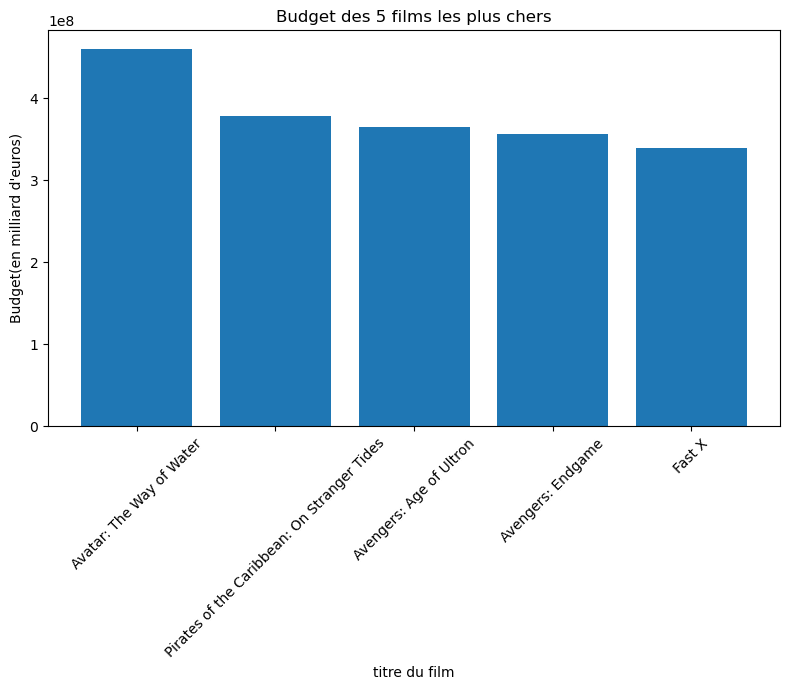

In [33]:
plt.figure(figsize=(8, 7))
plt.bar(range(len(top_5_expensive_movies)), top_5_expensive_movies['budget'])
plt.xlabel('titre du film')
plt.ylabel("Budget(en milliard d'euros)")
plt.title('Budget des 5 films les plus chers')
plt.xticks(range(len(top_5_expensive_movies)), top_5_expensive_movies['title'], rotation=45)
plt.tight_layout()
plt.show()

# Moyenne du budget par catégorie du film

In [34]:
genres_with_budget = movies_data.explode('genres')[['genres', 'budget']]
# Calcul de la moyenne des budgets par genre
average_budget_by_genre = genres_with_budget.groupby('genres')['budget'].mean()
print("Moyenne des budgets par genre :")
print(average_budget_by_genre)

Moyenne des budgets par genre :
genres
Action             3.703105e+07
Adventure          4.991111e+07
Animation          2.329480e+07
Comedy             2.190220e+07
Crime              2.175015e+07
Documentary        1.178846e+06
Drama              1.679477e+07
Family             3.259011e+07
Fantasy            3.667179e+07
History            2.539565e+07
Horror             9.286637e+06
Music              1.600934e+07
Mystery            1.771753e+07
Romance            1.532880e+07
Science Fiction    3.742086e+07
TV Movie           8.499553e+05
Thriller           2.058452e+07
War                2.306122e+07
Western            1.578088e+07
Name: budget, dtype: float64


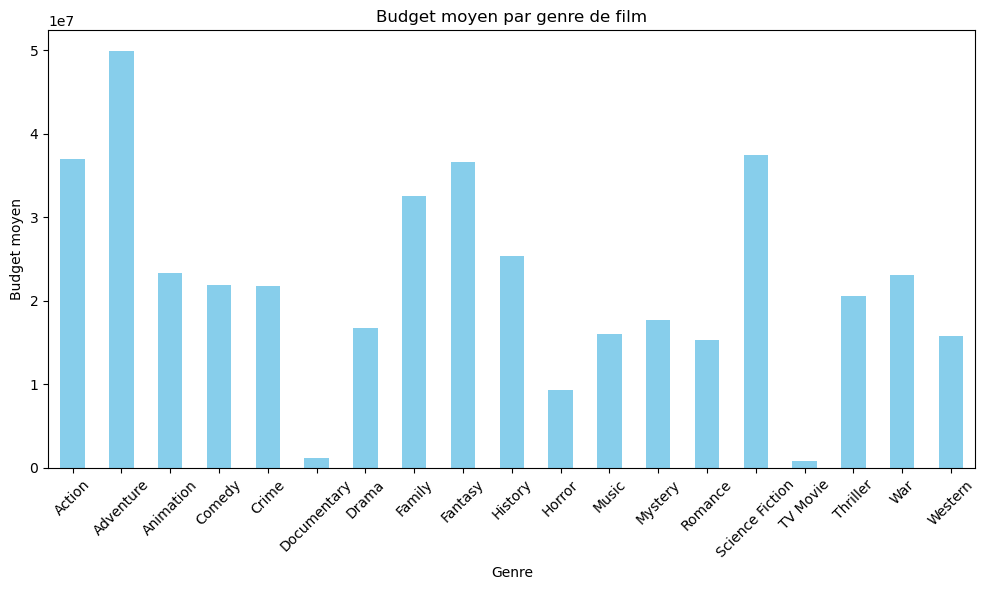

In [35]:
plt.figure(figsize=(10, 6))
average_budget_by_genre.plot(kind='bar', color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Budget moyen')
plt.title('Budget moyen par genre de film')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Langue et Film

In [36]:
movies_data['original_language'].unique()

array(['en', 'ko', 'no', 'fr', 'ja', 'es', 'ar', 'mn', 'zh', 'uk', 'hi',
       'tl', 'de', 'fi', 'th', 'nl', 'pt', 'id', 'it', 'pl', 'te', 'sv',
       'ru', 'ml', 'is', 'ca', 'cn', 'da', 'tr', 'yo', 'el', 'ig', 'sr',
       'ta', 'cs', 'mk', 'bn', 'hr', 'km', 'ga', 'nb', 'he', 'ro', 'hu',
       'vi'], dtype=object)

# Nombre de Film Par Langue

In [37]:
langues_exploded = movies_data['original_language'].explode()
# Compter le nombre de films par genre
langues_counts = langues_exploded.value_counts()
print("Nombre de films par langue :")
print(langues_counts)

Nombre de films par langue :
original_language
en    7391
ja     410
fr     251
es     171
ko     119
it     115
zh      67
de      59
cn      51
ru      31
da      24
no      24
sv      22
hi      19
nl      17
pt      17
pl      17
tl      12
th      11
id       8
fi       8
te       6
ar       4
tr       4
cs       3
is       3
sr       3
ta       2
el       2
ca       2
uk       2
km       2
he       1
ro       1
hu       1
nb       1
ga       1
yo       1
hr       1
bn       1
mk       1
ig       1
ml       1
mn       1
vi       1
Name: count, dtype: int64


on représente le nombre de film par langue sur une échelle logarithmique 

<Axes: title={'center': 'le nombre de film par langue'}, xlabel='original_language'>

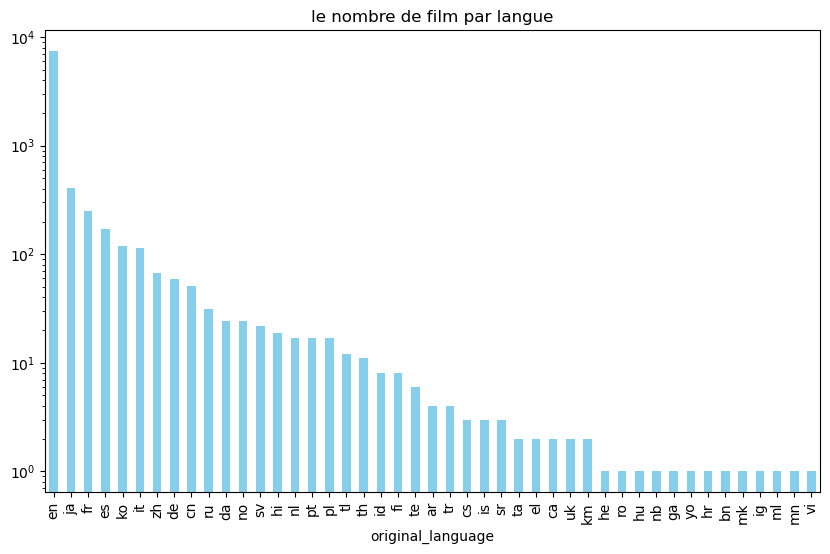

In [38]:
plt.figure(figsize=(10, 6))
langues_counts.plot(kind='bar', color='skyblue',logy=True,title='le nombre de film par langue')

# Budget Et Langue De Film

In [39]:
budget_film_by_language = movies_data.groupby('original_language')['budget'].mean()


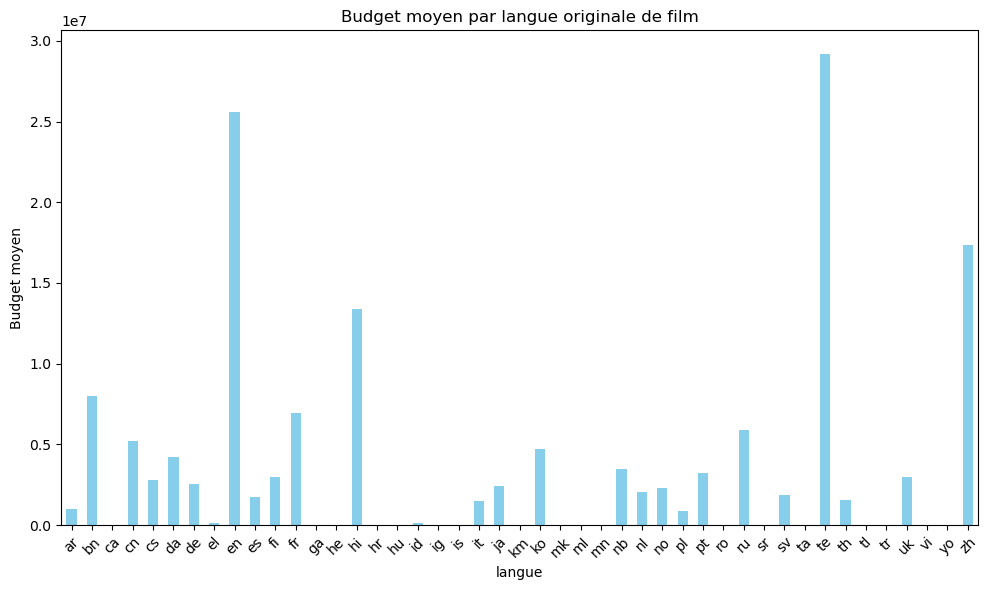

In [40]:
plt.figure(figsize=(10, 6))
budget_film_by_language.plot(kind='bar', color='skyblue')
plt.xlabel('langue')
plt.ylabel('Budget moyen')
plt.title('Budget moyen par langue originale de film')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

te ? cette langue a seulement 6 films mais en moyenne il dépense plus de 3 milliard d'euro pour chque film

# Les Films dans le temps 

In [41]:
movies_data['release_date']
movies_data['release_date']=pd.to_datetime(movies_data['release_date'])



In [42]:
movies_data['release_year']=[date.year for date in movies_data['release_date']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


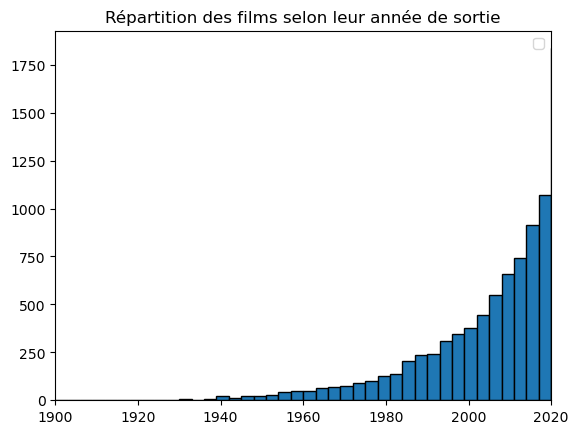

In [43]:
plt.hist(movies_data["release_year"], bins = [x for x in range(1900, 2025,3)] ,
         
         ec = "black")

plt.xlim([1900,2020])
plt.title("Répartition des films selon leur année de sortie")
plt.legend()
plt.show()

# Sélectionner les colonnes intéressantes

In [44]:

selected_columns=['id','title','original_title','overview','release_date','adult','popularity','vote_average','vote_count','poster_path','runtime','genres','production_companies','production_countries','spoken_languages','credits','keywords']
movies_data=movies_data[selected_columns]


In [45]:
# Filtrer les films dont la date est antérieure à '2023-10-18'
movies_data = movies_data[movies_data['release_date'] <= '2023-12-31']
movies_data.reset_index(drop=True)


,id,title,original_title,overview,release_date,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,credits,keywords
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,2023-10-18,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]","[{'id': 194232, 'logo_path': '/oE7H93u8sy5vvW5...",[United States of America],"[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi..."
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,2023-01-05,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]","[{'id': 89171, 'logo_path': '/c3ttVfx0itQzk2vO...",[United States of America],"[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta..."
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,2023-12-06,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]","[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI...","[United Kingdom, United States of America]","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}..."
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",2023-10-12,False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]","[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...",[United States of America],"[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}..."
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,2023-11-17,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]","[{'id': 878, 'logo_path': '/e2AZdsQdkhN0qJhoN4...","[Australia, United States of America]","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8857,11157,She-Devil,She-Devil,A cunning and resourceful housewife vows reven...,1989-12-08,False,27.259,5.889,348,/jWYAXtdYF804aT1muO0G6FuR2Fa.jpg,99,[Comedy],"[{'id': 41, 'logo_path': '/xAot4SSOIHiWQ2WEnVX...",[United States of America],"[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 2751, 'name': 'career wom..."
8858,11085,Mutiny on the Bounty,Mutiny on the Bounty,The Bounty leaves Portsmouth in 1787. Its dest...,1962-11-08,False,21.260,7.000,269,/caxk06SANEacvycZFiApv1LA6Kl.jpg,185,"[Adventure, Drama, History]","[{'id': 14091, 'logo_path': None, 'name': 'Arc...",[United States of America],"[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 911, 'name': 'exotic isla..."
8859,152747,All Is Lost,All Is Lost,"During a solo voyage in the Indian Ocean, a ve...",2013-08-23,False,29.012,6.600,1504,/9cVA4oX2xHgiglv6hemxwAaofsq.jpg,106,"[Action, Adventure, Drama]","[{'id': 14861, 'logo_path': None, 'name': 'Bef...",[United States of America],"[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 658, 'name': 'sea'}, {'id..."
8860,26149,Music of the Heart,Music of the Heart,Story of a schoolteacher's struggle to teach v...,1999-10-29,False,30.409,6.704,199,/maqYjELEaeCr3EtN7KNLTAwycS5.jpg,124,"[Music, Drama]","[{'id': 1600, 'logo_path': None, 'name': 'Crav...",[United States of America],"[{'english_name': 'Spanish', 'iso_639_1': 'es'...","{'cast': 

### IV. Modélisation

Pour notre modèle on conserve que les films dont les features ci dessous existent ça sera plus crédible

In [58]:
movies_reco=movies_data[["id","title","overview","genres","keywords","cast","crew"]]
movies_reco.head()

,id,title,overview,genres,keywords,cast,crew
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,"[Crime, Drama, History]","[husband wife relationship, based on novel or ...","[Leonardo DiCaprio, Lily Gladstone, Robert De ...",[Martin Scorsese]
1,897087,Freelance,An ex-special forces operative takes a job to ...,"[Action, Comedy]","[coup d'etat, dictatorship, political assassin...","[John Cena, Alison Brie, Juan Pablo Raba]",[Pierre Morel]
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...,"[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[Timothée Chalamet, Calah Lane, Keegan-Michael...",[Paul King]
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...","[Animation, Family, Music, Fantasy, Comedy]","[pop star, brother, musical, sequel, based on ...","[Anna Kendrick, Justin Timberlake, Camila Cabe...",[Walt Dohrn]
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...,"[Animation, Comedy, Family]","[classroom, musical, bucket list]","[Adam Sandler, Bill Burr, Cecily Strong]",[Robert Smigel]


In [59]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1
movies_reco['cast'] = movies_reco['cast'].apply(collapse)
movies_reco['crew'] = movies_reco['crew'].apply(collapse)
movies_reco['genres'] = movies_reco['genres'].apply(collapse)
movies_reco['keywords'] = movies_reco['keywords'].apply(collapse)
movies_reco.head()

/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_41290/813522039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['cast'] = movies_reco['cast'].apply(collapse)
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_41290/813522039.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['crew'] = movies_reco['crew'].apply(collapse)
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_41290/813522039.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

,id,title,overview,genres,keywords,cast,crew
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,"[Crime, Drama, History]","[husbandwiferelationship, basedonnovelorbook, ...","[LeonardoDiCaprio, LilyGladstone, RobertDeNiro]",[MartinScorsese]
1,897087,Freelance,An ex-special forces operative takes a job to ...,"[Action, Comedy]","[coupd'etat, dictatorship, politicalassassinat...","[JohnCena, AlisonBrie, JuanPabloRaba]",[PierreMorel]
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...,"[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[TimothéeChalamet, CalahLane, Keegan-MichaelKey]",[PaulKing]
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...","[Animation, Family, Music, Fantasy, Comedy]","[popstar, brother, musical, sequel, basedontoy...","[AnnaKendrick, JustinTimberlake, CamilaCabello]",[WaltDohrn]
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...,"[Animation, Comedy, Family]","[classroom, musical, bucketlist]","[AdamSandler, BillBurr, CecilyStrong]",[RobertSmigel]


In [60]:
movies_reco['overview'] = movies_reco['overview'].apply(lambda x:x.split())
movies_reco["title_bis"]=movies_reco["title"].apply(lambda x:x.split())
movies_reco['label'] = movies_reco['overview']+movies_reco['title_bis']+movies_reco['genres'] + movies_reco['keywords'] + movies_reco['cast'] + movies_reco['crew']
data_model=movies_reco.drop(columns=['overview','genres','keywords','cast','crew',"title_bis"])
data_model['label'] = data_model['label'].apply(lambda x: " ".join(x))
data_model.head()

/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_41290/2911585339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['overview'] = movies_reco['overview'].apply(lambda x:x.split())
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_41290/2911585339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco["title_bis"]=movies_reco["title"].apply(lambda x:x.split())
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_41290/2911585339.py:3: SettingWithCopyWarning: 
A

,id,title,label
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...
1,897087,Freelance,An ex-special forces operative takes a job to ...
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for..."
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...


In [61]:
ps =PorterStemmer()
def stem(text): # stem("dancing")=>"danc"
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)
data_model["label"]=data_model["label"].apply(stem)
data_model["label"]=data_model["label"].apply(lambda x : x.lower())
data_model.head()

,id,title,label
0,466420,Killers of the Flower Moon,when oil is discov in 1920 oklahoma under osag...
1,897087,Freelance,an ex-speci forc oper take a job to provid sec...
2,787699,Wonka,willi wonka – chock-ful of idea and determin t...
3,901362,Trolls Band Together,"when branch' brother, floyd, is kidnap for hi ..."
4,1075794,Leo,jade 74-year-old lizard leo ha been stuck in t...


In [62]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8292 entries, 0 to 8291
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8292 non-null   int64 
 1   title   8292 non-null   object
 2   label   8292 non-null   object
dtypes: int64(1), object(2)
memory usage: 194.5+ KB


In [63]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(data_model['label']).toarray()

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vector)
similarity

array([[1.        , 0.        , 0.        , ..., 0.01690309, 0.06172134,
        0.        ],
       [0.        , 1.        , 0.03774257, ..., 0.09200874, 0.        ,
        0.03513642],
       [0.        , 0.03774257, 1.        , ..., 0.02344036, 0.0855921 ,
        0.10741723],
       ...,
       [0.01690309, 0.09200874, 0.02344036, ..., 1.        , 0.02608203,
        0.04364358],
       [0.06172134, 0.        , 0.0855921 , ..., 0.02608203, 1.        ,
        0.        ],
       [0.        , 0.03513642, 0.10741723, ..., 0.04364358, 0.        ,
        1.        ]])

In [65]:
similarity.shape

(8292, 8292)

In [66]:
def recommend(movie,m):
    index = data_model[data_model['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:m+1]:
        print(data_model.iloc[i[0]].title)

In [74]:
recommend("Avatar",5)

Inuyashiki
Aliens in the Attic
Skylines
Aliens vs Predator: Requiem
Battle: Los Angeles
Aliens
Titan A.E.
Small Soldiers
Rim of the World
Attraction
Independence Day


In [70]:
import pickle
pickle.dump(data_model.to_dict(),open("movies_dict.pkl","wb"))
pickle.dump(movies_data.to_dict(),open("movies_details.pkl","wb"))
pickle.dump(similarity,open("similarity.pkl","wb"))